In [1]:
using DifferentialEquations, Optim, Plots, DataFrames, LinearAlgebra, CSV, Tables, Statistics, MuladdMacro, thyrosimIM

### Data

##### Sample Data

In [2]:
# Import sample data
sample_IM = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/DDR_initials.csv")); # DDR Hashimoto Steady-State
patient_list = [7228995, 62352978, 78490026, 1179621568, 1708857679]
sample_IM.t = 12 * sample_IM.t;

##### Import Patient Data

In [3]:
function normalize_time(labs_df, dose_df)
    t_0 = min(minimum(labs_df.t), minimum(dose_df.t))
    labs_df.t = (labs_df.t .- t_0).*24
    dose_df.t = (dose_df.t .- t_0).*24
    patient_data = (labs_df, dose_df)
    return patient_data
end

function import_patient(patient_ID)
    data_dir = "C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/Parsed_data/"
    info_path = data_dir * "patient-$patient_ID.txt"
    labs_path = data_dir * "patient-$patient_ID.csv"
    dose_path = data_dir * "patient_meds-$patient_ID.csv"
    labs_df = DataFrame(CSV.File(labs_path))
    dose_df = DataFrame(CSV.File(dose_path))

    patient_data = normalize_time(labs_df, dose_df)
    return patient_data
end

import_patient (generic function with 1 method)

### _Important_

`dose_df` must be defined explicitly in global scope so that callback is able to access medications. 

In [4]:
patient = import_patient(patient_list[3])
labs_df = patient[1]
dose_df = patient[2];

##### Patient Plotting

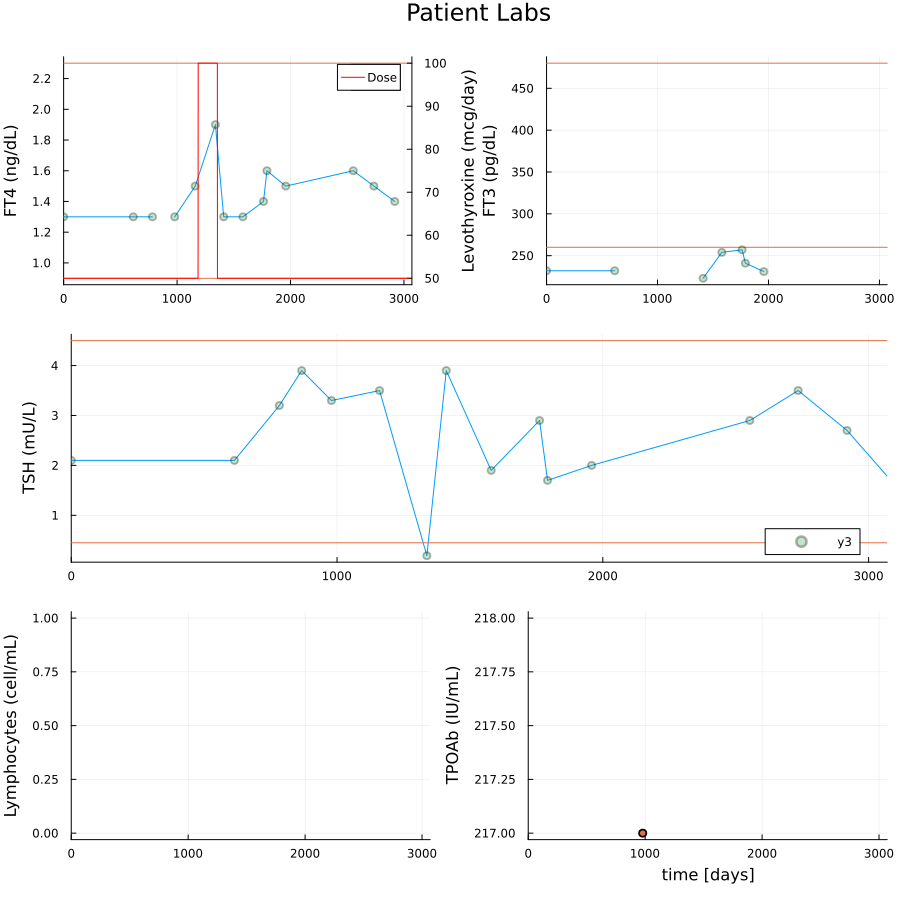

In [5]:
plot_patient(patient)

### Parameters

In [6]:
function import_parameters(param_path)
    # Initialize an empty vector to store the values
    values = Vector{Float64}()

    # Open the file in read mode
    file = open(param_path, "r")

    try
        # Read the entire file content as a string
        file_content = read(file, String)

        # Split the content by spaces to obtain individual values
        value_strings = split(file_content, ",")

        # Convert each value to a Float64 and append to the vector
        for val_str in value_strings
            push!(values, parse(Float64, val_str))
        end

    finally
        # Close the file when done reading
        close(file)
    end

    return values
end;

### Fitting Functions

In [7]:
# Run simulation for certain amount of days (hopefully to steady state)
function find_patient_ic!(ic, p, days; model = thyrosimIM!)
    tspan = (0.0, 24.0 * days)
    prob = ODEProblem(model, ic, tspan, p)
    sol = solve(prob)
    ic .= sol[end]
end

# Read doseages from lookup table (dose_df) MUST be defined prior to fitting
function add_dose!(integrator)
    integrator.u[10] = dose_df.Levothyroxine[findfirst(==(integrator.t), dose_df.t)]/(24*4.85625)
    integrator.u[12] = dose_df.Lyothyronine[findfirst(==(integrator.t), dose_df.t)]/(24*61031.25)
end

dose_times = dose_df.t
dose_callback = PresetTimeCallback(dose_times, add_dose!);

In [8]:
import NaNMath # handles log of negative number that can occur due to adaptive ODE solvers


function combine_params(free_parameters::Vector, fixed_parameters::Vector, free_indicies::Vector)
    #print("Free Parameters: $(length(free_parameters)), Fixed Parameters: $(length(fixed_parameters)), Free Indices: $(length(free_indicies)).")
    if isempty(free_indicies) #assume fixed... + free... is correctly ordered parameter Vector
        p = [fixed_parameters; free_parameters] 
    else # we must have free_parameters in same order as free_indicies. fixed_parameters must be in ascending index order
        p = zeros(length(free_parameters) + length(fixed_parameters))
        fixed_indicies = setdiff(1:size(p, 1), free_indicies)
        for i in eachindex(p)
            if i in(free_indicies)
                p[i] = free_parameters[findall(x -> x == i, free_indicies)[1]] 
            else   
                p[i] = fixed_parameters[findall(x -> x == i, fixed_indicies)[1]] 
            end
        end
    end
    return p
end

function log_lsq_loss(sol, time, data, plot_no)
    data_columns = names(data)[3:7] # this selects T4,T3, TSH, Lymphocytes, Ab
    sol_indicies = [[1],[4],[7],[20,21,22],[25]] # indicies for T4, T3, TSH, Lymphocytes, Ab
    loss_vector = [0.0,0.0,0.0,0.0,0.0] # loss for T4,T3, TSH, Lymphocytes, Ab respectivley
    for (i, column) in enumerate(data_columns)
        if any(!ismissing, data[!, column])
            μ = mean(skipmissing(data[!, column]))
            for (j, t) in enumerate(time)
                datapoint = data[!, column][j]
                if ismissing(datapoint)
                    loss_vector[i] = loss_vector[i]
                else
                    predicted = 0
                    if column == "FT4"
                        predicted = FT4(sol(t)[sol_indicies[i]])[1]
                        loss_vector[i]+= ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    elseif column == "FT3"
                        predicted = FT3(sol(t)[sol_indicies[i]])[1]
                        loss_vector[i]+= ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    elseif column == "TSH"
                        predicted = TSHfit(sol(t)[sol_indicies[i]])[1]
                        loss_vector[i]+= ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    elseif column == "Ab"
                        predicted = TPOConvert(sol(t)[sol_indicies[i]])[1]
                        loss_vector[i]+= ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    else
                        for state_variable in sol_indicies[i]
                            predicted += sol(t)[state_variable][1]
                        end
                        loss_vector[i] += ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    end
                end
            end
        else
            loss_vector[i] += 0
        end
    end

    global plot_no
    if mod(plot_no, 10) == 0 
        optim_plotter(sol, data, title = "Optimization progress frame $(plot_no)", save_to_file = true, plot_no=plot_no)
    end
    plot_no += 1
    
    global GLOBAL_LOSS
    GLOBAL_LOSS = vcat(GLOBAL_LOSS, loss_vector')
    
    return loss_vector
end

function bounded_log_lsq_loss(sol, time, data, plot_no)
    data_columns = names(data)[3:7] # this selects T4,T3, TSH, Lymphocytes, Ab
    sol_indicies = [[1],[4],[7],[20,21,22],[25]] # indicies for T4, T3, TSH, Lymphocytes, Ab
    loss_vector = [0.0,0.0,0.0,0.0,0.0] # loss for T4,T3, TSH, Lymphocytes, Ab respectivley
    bounds = [[0.0,40.0],[0.0,3.0e3],[0.0,300.0],[100.0,3000.0],[0, 2.0e3]]
    for (i, column) in enumerate(data_columns)
        warn = true
        if any(!ismissing, data[!, column])
            μ = mean(skipmissing(data[!, column]))
            for (j, t) in enumerate(time)
                datapoint = data[!, column][j]
                if ismissing(datapoint)
                    loss_vector[i] = loss_vector[i]
                else
                    predicted = 0
                    if column == "FT4"
                        predicted = FT4(sol(t)[sol_indicies[i]])
                    elseif column == "FT3"
                        predicted = FT3(sol(t)[sol_indicies[i]])
                    elseif column == "Ab"
                        predicted = TPOConvert(sol(t)[sol_indicies[i]])
                    else
                        for state_variable in sol_indicies[i]
                            predicted += sol(t)[state_variable]
                        end
                    end
                    # if predicted out of bounds, assign large penalty. Else assign log_sql_loss
                    weighted_loss = ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    (predicted < bounds[i][1] || predicted > bounds[i][2] ) : (loss_vector[i] += 1e2*weighted_loss) : (loss_vector[i] += weighted_loss)
                    if warn
                        predicted < bounds[i][1]  && println("$(data_columns[i]) < 0")
                        predicted > bounds[i][2] && println("$(data_columns[i]) > $(bounds[i][2])")
                        warn = false
                    end
                end
            end
        else
            loss_vector[i] += 0
        end
    end
    
    global plot_no
    #if mod(plot_no, 10) == 0 
    optim_plotter(sol, data, title = "Optimization progress frame $(plot_no)", save_to_file = true, plot_no=plot_no)
    #end
    plot_no += 1

    
    global GLOBAL_LOSS
    GLOBAL_LOSS = vcat(GLOBAL_LOSS, loss_vector')
    
    return loss_vector 
end

function objective(
    free_parameters::Vector,
    fixed_parameters::Vector,
    free_index::Vector,
    ics::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    model=thyrosimIM!,
    loss_function::Function=neg_logl,
    solver=Rosenbrock23(),
    use_callback::Bool = false,
    solver_opts::Any = [])

    # Bound solution space - needs to be replaced with Optim native options
    for (i, parameter) in enumerate(free_parameters[1:end-5])
        if !(lb[i] ≤ parameter ≤ ub[i])
            # println("Parameter $i with value $parameter was out of bounds $(lb[i]) -- $(ub[i]).")
            return 10e6
        end
    end

    # assign t from data, initialize thyrosim problem and compute solution
    t = data.t; tspan = (t[1], t[end])

    sol = simulate(model, ics, tspan, free_parameters, fixed_parameters, free_index, warmup = true, warmup_period = 1, use_callback = use_callback)

    # For now, we are fitting 5 state variables (1,4,7, 20:22, 25). Thus, last 6 parameters must be
    # for MLE: solver_opts = corresponding variance of the state variables for MLE, can make variable SV number in future
    # for bounded_log_lsq_loss: solver_opts = bounds for each SV
    loss = loss_function(sol, t, data, solver_opts)
    
    total_loss = sum(loss) + 100 # add 100 to ensure model runs for entire time

    return total_loss
end

"""
**Required Args**
 - `params`: A vector containing all parameters used in the ODE Model
 - `free_index`: A vector of integer values specifying the indices of free parameters to be fit by the optimization routine. One parameter for each state variable variance **MUST** be provided at the end of the parameter list.
 - `ics`: Initial state variable values
 - `lb` and `ub`: Vectors with lower and upper bounds for free parameters (must be same length)
 - `data`: Dataframe with patient lab values

 ### _Note_: a Dataframe named dose_df with patient LT4 dosing MUST be defined or the function will throw an error
 
 **Keyword Args**
 - `model`: defaults to `thyrosimIM!`. Can provide alternate model here
 - `loss_function`: How loss is calculated from data (WLS, MLE, custom function....)
 - `use_callback`: specify true if patient has medication values. These must be provided as a dataframe named `dose_df`
 - `optimization_routine`: Nelder-Mead(), Newton(), LBFGS(), etc.. See [Optim.jl Documentation](https://docs.sciml.ai/Optimization/stable/optimization_packages/optim/) for available search routines
 - `iterations`: maximum iterations to run for. Defaults to 100k iterations
 - `time_limit`: maximum time (in seconds) to run parameter search. Note this applies only to optim and does not account for time taken to actually solve ODE problem and calculate loss. Usually takes about double the time you enter here to complete the search if maximum iterations is not reached
 """
function fit_all(
    params::Vector,
    free_index::Vector{Int},
    ics::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    model=thyrosimIM!,
    loss_function::Function=lsq_loss,
    use_callback::Bool = false,
    optimization_routine = NelderMead(),
    iterations::Int = 100000,
    time_limit::Number = 200.0,
    solver_opts::Any = [])

    # set fixed parameter indexing and split params vector into free and fixed
    fixed_index = Int.(setdiff(collect(1:length(params)), free_index))
    free_params_initial = params[free_index]
    fixed_params = params[fixed_index]

    # print("Free Parameters: $(params[free_index]). Fixed Parameters: $(params[fixed_index])")
    global plot_no
    plot_no = 1

    print("Fitting...")
    solution = optimize(free_params -> objective(free_params, fixed_params, free_index, ics, lb, ub, data, 
        model=model, loss_function=loss_function, use_callback=use_callback, solver_opts=plot_no), 
        free_params_initial, optimization_routine, 
        Optim.Options(time_limit = time_limit, iterations = iterations, g_tol=1e-15,
        show_trace = false, allow_f_increases=true))
    return solution
end

fit_all

In [9]:
# Convert from internal to plotting/fitting units
function FT4(TT4)
    return (777.0 * 0.02 * TT4[1])/(13)
end

# Welsh KJ, Soldin SJ. doi: 10.1530/EJE-16-0193. converts TT3 (mcg/L) to FT3 (pg/dL)
function FT3(TT3)
    return (651.0 * TT3[1] * 100)/(9.6)
end

function TPOConvert(TPOAb)
    return ((TPOAb)[1])*1.5e9
end

function TGConvert(TG)
    return ((TG)[1])*6.022e8
end

function TSHfit(TSH)
    return 10*(56/5.2)*TSH
end

TSHfit (generic function with 1 method)

In [10]:
function simulate(model, ic, tspan, free_parameters, fixed_parameters, free_indices::Vector; use_callback::Bool = false, solver = Rosenbrock23(), warmup::Bool=false, warmup_period::Int=30)
    parameters = combine_params(free_parameters[1:end-5], fixed_parameters, free_indices[1:end-5])
    if warmup
        find_patient_ic!(ic, parameters, warmup_period)
    end
    if use_callback
        problem = ODEProblem(model, ic, tspan, parameters)
        sol = solve(problem, solver, callback = dose_callback, tstops = dose_times)
        return sol
    else
        problem = ODEProblem(model, ic, tspan, parameters)
        sol = solve(problem, solver)
        return sol
    end
end 

simulate (generic function with 1 method)

In [11]:
all_params = initialize_all()
free_params = initialize_free()
optimal_params = import_parameters("optimal_params_072723.txt")
initial_conditions = ics()
fixed_params = fixed_parameters()
meha_params = meha_free()
meha_initial_conditions = meha_ics();

### Test Simulation

In [12]:
function simplot(sol; alt_model::Bool = false, automargins::Bool = true, title = "Unit Test 1")
    
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = FT4.(sol[1, :])
    T3 = FT3.(sol[4, :])
    T4T3Labels = ["FT4 (ng/dL)", "FT3 (pg/dL)"]
    T4T3Ranges = [[0.9, 2.3], [260, 480]]
    TSH = TSHfit.(sol[7, :])
    Bcell = sol[20, :]
    Pcell = sol[21, :]
    Tcell = sol[22, :]
    Lymphocytes = sol[20, :].+sol[21, :] .+ sol[22, :]
    TPOAb = TPOConvert.(sol[25, :]) # convert to pM from molecules/mL
    alt_model && (TPOAb = TPOConvert.(sol[24, :])) # convert to pM from molecules/mL
    alt_model && (TGAb = TGConvert.(sol[25, :]))

    xlim=(0,sol.t[end]/24) 
    if automargins
        t4lim = max(1.2*maximum(T4), T4T3Ranges[1][2]*1.1)
        t3lim = max(1.2*maximum(T3), T4T3Ranges[2][2]*1.1)
        tshlim = max(1.2maximum(TSH), 5.5)
        Llim = 1.2maximum(Lymphocytes)
        TPOlim = 1.2maximum(TPOAb)
        alt_model && (TGlim = 1.2maximum(TGAb))
    end

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), xlim=xlim, label="", ylabel=T4T3Labels[1])
    p1 = hline!(T4T3Ranges[1], label= "")
    #p1 = scatter!(data.t./24, data.T4, alpha = 0.3, label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), xlim=xlim, label="", ylabel=T4T3Labels[2])
    p2 = hline!(T4T3Ranges[2], label= "")
    #p2 = scatter!(data.t./24, data.T3, alpha = 0.3, label= "")
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), xlim=xlim, label="", ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")
    #p3 = scatter!(data.t./24, data.TSH, alpha = 0.3, label= "")

    p4 = plot(sol.t / 24.0, Lymphocytes, ylabel="Lymphocytes (cell/mL)", ylim=(0,Llim), xlim=xlim, label="")
    #p4 = scatter!(data.t./24, data.Lymphocytes, alpha = 0.3, label= "")
    p4 = plot!(sol.t /24.0, Bcell, label = "B-Cells")
    p4 = plot!(sol.t /24.0, Tcell, label = "T-Cells")
    p4 = plot!(sol.t /24.0, Pcell, label = "Plasma Cells")

    p5 = plot(sol.t / 24.0, TPOAb, ylabel="TPOAb (IU/mL)", xlabel="time [days]", ylim=(0,TPOlim), xlim=xlim, label="")
    #p5 = scatter!(data.t./24, data.Ab, alpha = 0.3, label= "")
    
    if alt_model
        p6 = plot(sol.t / 24.0, TGAb, ylabel="TGAb (IU/mL)", xlabel="time [days]", ylim=(0,TGlim), xlim=xlim, label="")
        l = @layout [a b ; c ; d e f]
        plot!(size=(900,900))
        p_main = plot!(p1, p2, p3, p4, p5, p6, layout=l)
    else
        # p6 = plot(dose_df.t / 24.0, dose_df.Levothyroxine, ylabel="Oral Levothyroxine (mcg/day)", xlabel = "time [days]", label="")
        l = @layout [a b ; c ; d e]
        plot!(size=(900,900))
        p_main = plot!(p1, p2, p3, p4, p5, layout=l)
    end
    

    p_main[:plot_title] = title
    plot(p_main)
end;

In [13]:
#test_sim = simulate(meha_model!, meha_initial_conditions, (0,2120), meha_params, fixed_params)
test_sim_base = simulate(thyrosimIM!, initial_conditions, (0,2120), optimal_params, fixed_params, [], use_callback = false);

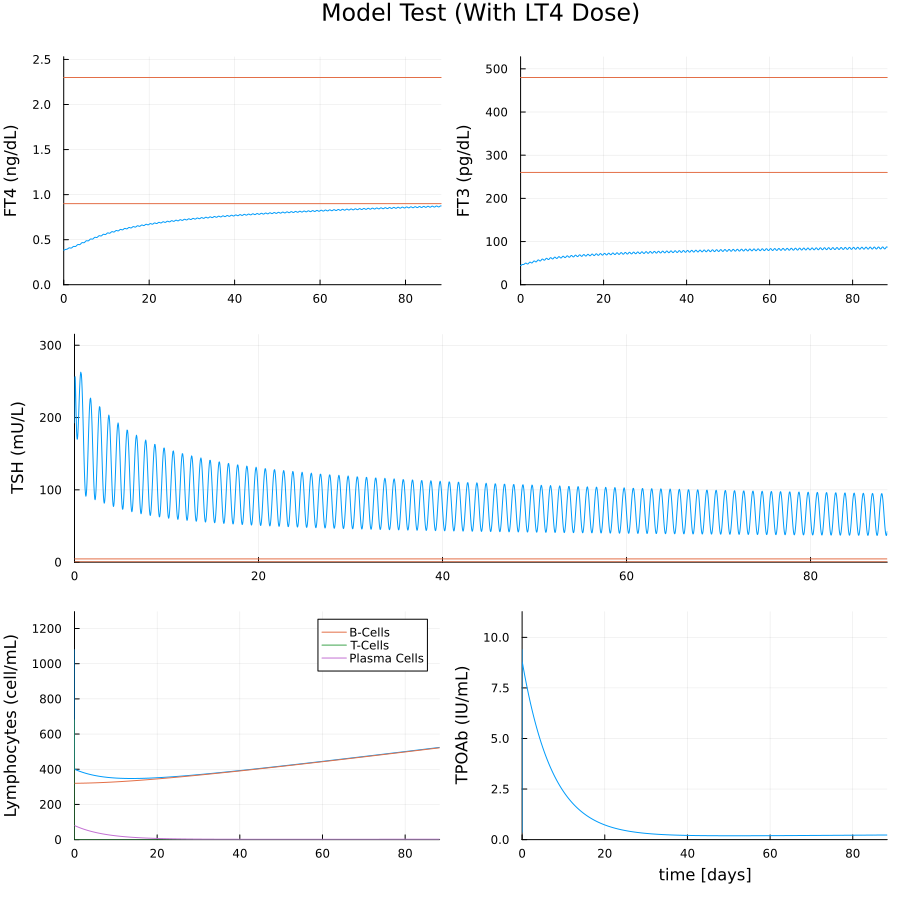

In [14]:
test_p = simplot(test_sim_base, title="Model Test (With LT4 Dose)")

### Parameter Fitting

Note that free indices **MUST** be increasing order.

In [46]:
#1,11,19,28,31,34
free_indicies = Int.(vcat([1,11,19,31,34,50],collect(83:105))) #last 5 are variances for each of the state variables
# Parameter Bounds
lb = zeros(size(free_indicies)[1])
ub = 1e5*all_params[free_indicies]
loss_function = log_lsq_loss;

Something is wrong with fitting due to dose callback... need to fix this to fit the non-dose patients

In [47]:
GLOBAL_LOSS = [0.0 0.0 0.0 0.0 0.0;];

- Optimal parameter reading may be an issue
- Toggle optimal parameter use with the boolean in `initialize_all` function. If it consistently throws dtmin errors, may need to undo optimal parameter reuse changes.
- 3320 sec is max with normal settings and NelderMead(). 
- `p[13], p[14]` very labile, consider rethinking cytokine involvement in T-cell response

In [48]:
fitting_trial = fit_all(initialize_all(optimal=false, optimal_path = "optimal_params_072723.txt"), free_indicies, initial_conditions, lb, ub, labs_df,
                        model=thyrosimIM!, loss_function=loss_function, use_callback=true, optimization_routine = NelderMead(), time_limit = 3000.0)
# fitting_trial_meha = fit_all(meha_params, fixed_params, meha_initial_conditions, lb, ub, sample_IM, model=meha_model!, loss_function=loss_function,
#    use_callback=true, optimization_routine = NelderMead(), time_limit=100.0)

Fitting...

 * Status: failure (exceeded time limit of 3000.0)

 * Candidate solution
    Final objective value:     1.271715e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-15

 * Work counters
    Seconds run:   11388  (vs limit 3000)
    Iterations:    712
    f(x) calls:    1306


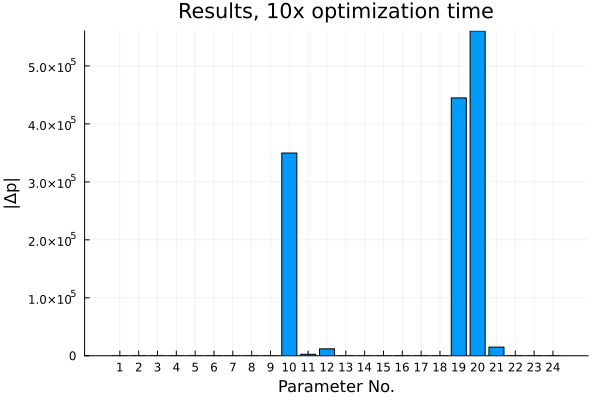

In [28]:
ticks = length(fitting_trial.minimizer[1:end-5])
bar(abs.(fitting_trial.minimizer[1:end-5] - initialize_all(optimal=false, optimal_path="")[free_indicies[1:end-5]]), title="Results, 10x optimization time", xticks = (collect(1:ticks), collect(1:ticks)),
    label="", ylabel="|Δp|", xlabel="Parameter No.")
#scatter(abs.(fitting_trial_meha.minimizer-meha_params))

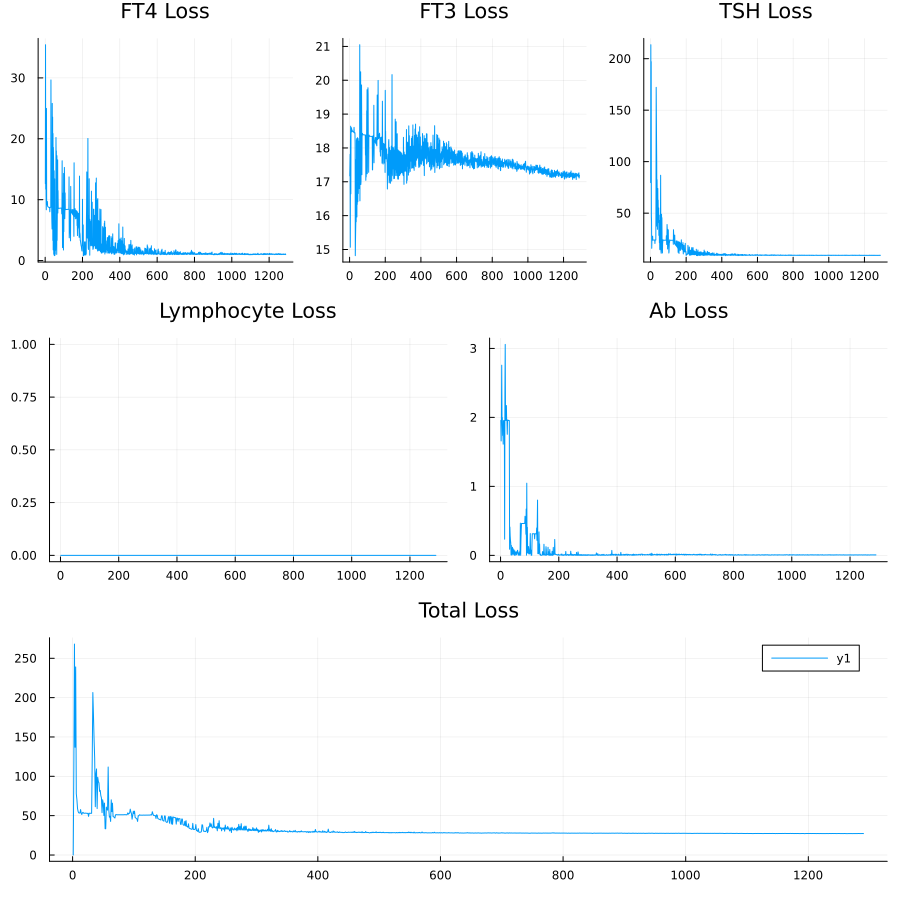

In [76]:
p1 = plot(GLOBAL_LOSS[2:end, 1], title="FT4 Loss", label = "")
p2 = plot(GLOBAL_LOSS[2:end, 2], title="FT3 Loss", label = "")
p3 = plot(GLOBAL_LOSS[2:end, 3], title="TSH Loss", label = "")
p4 = plot(GLOBAL_LOSS[2:end, 4], title="Lymphocyte Loss", label = "")
p5 = plot(GLOBAL_LOSS[2:end, 5], title="Ab Loss", label = "")
total_loss_plot = []
for row in eachrow(GLOBAL_LOSS)
    row_sum = sum(row)
    push!(total_loss_plot, row_sum)
end
p6 = plot(total_loss_plot, title="Total Loss")
plot!(size=(900,900))
plot(p1,p2,p3,p4,p5,p6, layout = @layout[a b c ; d e; f])

### Plots

In [77]:
# Compute unfit and fitted solutions for visualization
# tspan=(0.0,720.0*100)
# ic = ics() 
# title = "PLACEHOLDER"
# sol_meha = simulate(meha_model!, meha_initial_conditions, tspan, fitting_trial.minimizer, fixed_parameters(), use_callback = true, warmup=false);

In [78]:
tspan=(0.0,720.0*100)
ic = ics() 
title = "Female patient, mild Hashimoto's under LT4 management"
sol = simulate(thyrosimIM!, initial_conditions, tspan, fitting_trial.minimizer, fixed_parameters(), free_indicies, use_callback = true, warmup=true);
#sol_prefit = simulate(thyrosimIM!, initial_conditions, tspan, initialize_free(), fixed_parameters(), use_callback = false, warmup=false);

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq C:\Users\Aidan\.julia\packages\OrdinaryDiffEq\SUoOD\src\solve.jl:560
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\kTUaf\src\integrator_interface.jl:574
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq C:\Users\Aidan\.julia\packages\OrdinaryDiffEq\SUoOD\src\solve.jl:560
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\kTUaf\src\integrator_interface.jl:574


retcode: DtNaN
Interpolation: specialized 2nd order "free" stiffness-aware interpolation
t: 1-element Vector{Float64}:
 0.0
u: 1-element Vector{Vector{Float64}}:
 [1.0974237344434106, 1.2332985723592225, 3.958893468185527, 0.046007698025526136, 0.10277658852301745, 0.5312896839492467, 0.02505886397565801, 18.51874582914632, 18.52609781235336, 0.0  …  0.030589464693031015, 0.030073676764338773, 0.02866037734598804, 0.026692460972310796, 22.82460854091261, 38.874903364182366, 31.4307289084174, 1.0054790594005922e10, 44269.32339031226, 1.5599929203491707e-7]

Maybe trying to do something model is not designed for... seems to fit the more "normal" data much better when dose is provided... Need to reevaluate

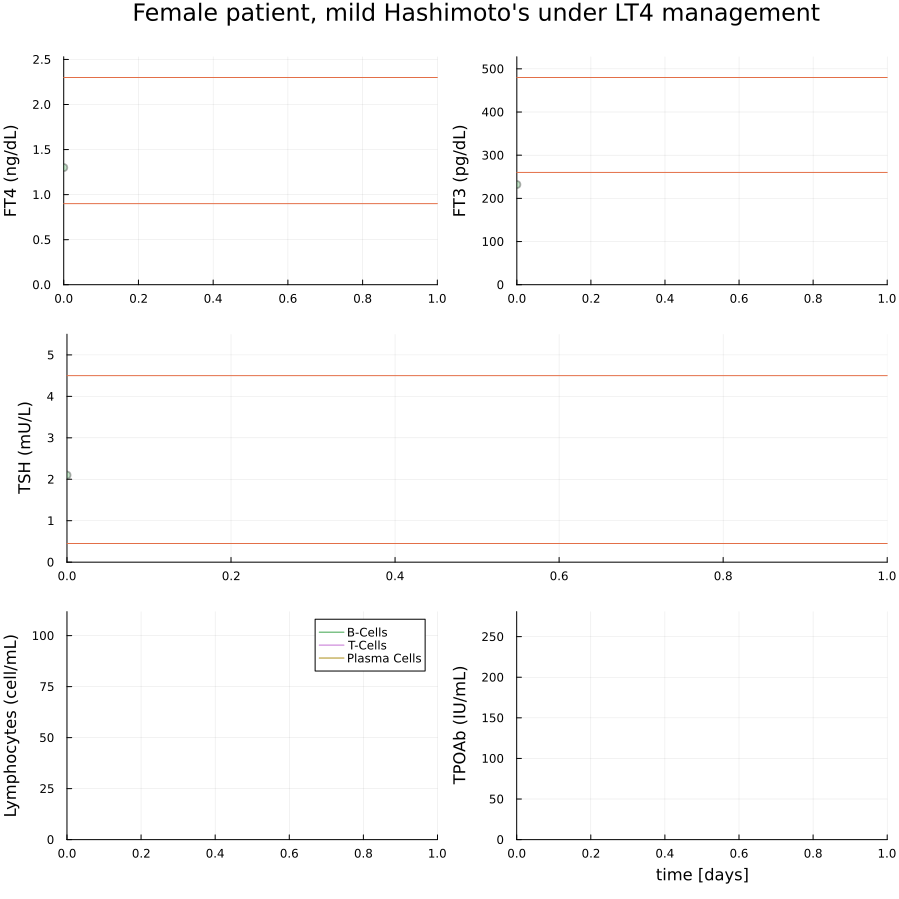

In [79]:
output_plotIM(sol, labs_df, title=title)

#### Save parameters to txt file

In [41]:
# vector = fitting_trial.minimizer

# file = open("optimal_params.txt", "w")
# write(file, join(vector, ","))
# close(file)

### Statistics

Estimated variances: [3.3877913882377584, 1.1805683651080532, 1.5179794745931277, 3.61182232814787, 1.00872668736427, -0.7726467674141038, -0.35243292431286094, -0.3686313249341252, 0.7160313350893045]

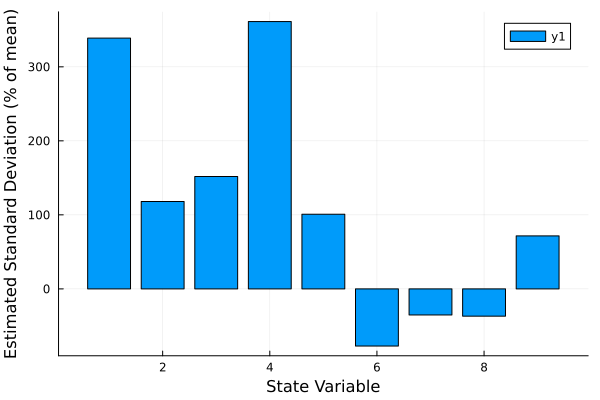

In [108]:
print("Estimated variances: ", fitting_trial.minimizer[18:26])
bar(100*fitting_trial.minimizer[18:26], xlabel = "State Variable", ylabel = "Estimated Standard Deviation (% of mean)")

In [98]:
function symlog(x::Number, base::Real = 10)
    if x == 0
        return 0.0
    else
        sign_x = sign(x)
        return sign_x * (log(abs(x)) / log(base) + 1)
    end
end

function normalize_matrix(matrix)
    D = Diagonal((sqrt.((diag(matrix)))))
    return inv(D)*matrix*inv(D)
end

function CV_estimation(
    free_parameters_guess::Vector,
    fixed_parameters::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    free_indicies::Vector=[],
    loss_function::Function=demeaned_neg_logl,
    variances::Vector=[])

    if isempty(free_indicies)
        fixed_indicies = collect(eachindex(fixed_parameters))
        free_indicies = setdiff(1:(size(fixed_indicies,1)+size(free_parameters_guess,1)), fixed_indicies)
    end

    optimal_sol = optimize(free_params -> objective(free_params, fixed_parameters,
        lb, ub, data, free_indicies=free_indicies, loss_function=lsq_loss),
        free_parameters_guess, Newton(), 
        Optim.Options(time_limit = 100.0, iterations = 0, g_tol=1e-5,
        show_trace = true, allow_f_increases=true, extended_trace=true))

    return optimal_sol
    #---------------------------------------------------#
    hessian = optimal_sol.trace[end].metadata["h(x)"]

    inv_hessian = try
        inv(hessian)
        return inv(hessian)
    catch problem
        if typeof(problem) == SingularException
            println("Inversion failed. Hessian is singular")
            return hessian
        else
            println(problem)
        end
    end
end

CV_estimation (generic function with 1 method)

In [14]:
# trace is not storing
CV_estimate = CV_estimation(MLE_trial.minimizer, fixed_params, lb, ub, sample_IM)

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


Iter     Function value   Gradient norm 


     0     7.926845e-01     1.066695e+77


 * Current step size: 1.0
 * time: 0.03600001335144043


 * g(x): [-1.0666948378041449e77, 6.283108163461921e23, -1.2610459750028964, -8.955448433074778e-8, -6.326942160919639e-7, 6.233806015691657e-7, 1.5534497960167626e24, 646.8274489082264, -1784.944882334411, 2.073031120468903, -0.43398880783862515, 34.78132965702819, 8.176280639757341e-10, -4.821353010182917e-10, -0.0019785924082800677, 1751.9000464300275, -0.1879333159520298, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


 * h(x): [1.9726016631692937e85 -9.725827158585155e84 -4.5425491337888347e83 3.608997555551298e75 -1.2881280520437482e77 2.6051048118885696e77 -1.9785941477068508e84 -2.976988520738028e84 4.7006295064931425e84 -1.0529358484562626e83 2.291576463958757e84 -2.1340773875373416e84 2.48518260354543e74 -1.2568615980569431e74 1.3632419687024944e80 -4.304505317460572e84 -9.169655028146503e82 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -9.725827158585155e84 1.5737170493574806e84 -2.8943685281913804e82 3.8556811891073646e74 -1.5786525067159838e76 1.612401114668581e76 9.035067984777956e83 -1.5690729242026202e84 1.7218901691740982e84 -1.1170572716647337e82 4.4904471185383483e83 -5.488423609715141e83 2.879871184833221e73 -1.2673707303721887e73 4.599611800502776e79 -1.956185097255702e84 -4.927438022553588e81 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -4.5425491337888347e83 -2.8943685281913804e82 375681.94641750347 -0.00334873240668576 0.2261292685709687 -0.21217145387902084 -2.158678029094298e81 8.069476548487765

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     7.926845e-01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = 1.07e+77 ≰ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit 100)
    Iterations:    0
    f(x) calls:    1
    ∇f(x) calls:   1
    ∇²f(x) calls:  1


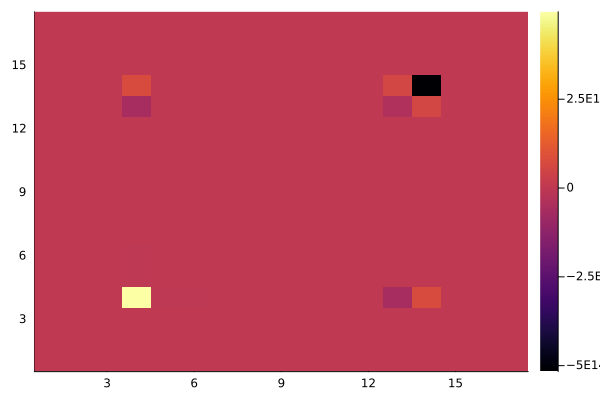

In [15]:
hess =  [5.086557062738764e7 -8.975713692101836e6 87721.39468827844 -0.0036138344026879496 -0.004169109330508855 0.0412036237380619 -1.4741641705452278e7 -1.415220801524967e6 -7.232587228557631e6 97680.68759578466 -3.4710551742016673e6 -1.2503822688478678e6 -1.881212748622513e-5 4.331103635188448e-6 3.717592557237433 7.230866191354491e6 602.5332329299303 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -8.975713692101836e6 2.3930191218268275e6 -20097.328623734415 0.0003923179193011434 -0.005702890229865123 0.00109862469334632 2.687370977333255e6 72092.9356058985 1.7620193666359484e6 -10598.562122166157 380617.8766720593 -146853.3437903449 3.3888286380636282e-6 -9.963711336140634e-7 -0.6646151759412562 -1.7616235209487602e6 -667.0786293996368 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 87721.39468827844 -20097.328623734415 750.672917753458 2.451237397663043e-5 0.00025870663443813716 -0.00010778125292582822 -23102.843414500356 -739.7527782619 -65890.18403806537 -661.2209930941463 -10650.256822027266 5136.194780535996 -4.774654266178749e-8 5.347429588044037e-8 0.0047717281398648665 65876.77626981586 30.51001457507274 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -0.0036138344026879496 0.0003923179193011434 2.451237397663043e-5 3.7740491955714115e-12 1.3289680219908628e-11 -1.1213298719172559e-11 0.0010989686844880939 0.0001725876146888288 -0.002218383926238594 -0.00010190227955872488 -5.469275126444685e-5 0.0004003325135622783 1.6022983112864047e-15 1.0962444990413473e-15 -3.214441567402506e-10 0.0022179522033147886 1.40538491564446e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -0.004169109330508855 -0.005702890229865123 0.00025870663443813716 1.3289680219908628e-11 2.993690506020081e-10 -2.69838687212555e-10 0.00550916791580176 0.0028076686020824825 -0.022471410432890544 -0.00035778696769167963 0.0034826519446613667 0.013925580041970174 -1.4079480183592112e-14 1.079784841512541e-14 -2.1837999003654676e-9 0.022467118268054004 2.5202451068291327e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0412036237380619 0.00109862469334632 -0.00010778125292582822 -1.1213298719172559e-11 -2.69838687212555e-10 3.5406467205514226e-10 -0.016286833474311473 -0.0043299566883707955 0.009761417935795439 0.0003025928484137311 -0.014160916558547974 -0.0176806906348114 -3.497897195888835e-14 6.641231465469611e-16 4.862481015239555e-9 -0.009759907459329314 -2.2600903165785402e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.4741641705452278e7 2.687370977333255e6 -23102.843414500356 0.0010989686844880939 0.00550916791580176 -0.016286833474311473 4.644851291599363e6 486567.7247246951 1.9976845998971164e6 -29662.864569440484 1.2673957838366851e6 735324.77851668 6.0310082873064206e-6 -1.2357312008009603e-6 -1.2003011311370468 -1.9972979332661182e6 178.05964930550965 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.415220801524967e6 72092.9356058985 -739.7527782619 0.0001725876146888288 0.0028076686020824825 -0.0043299566883707955 486567.7247246951 103078.4431964457 60341.5835371837 -4655.433536320925 223045.68682068586 224004.38903275877 6.492790297502281e-7 -4.731602464144343e-8 -0.13250625956622333 -60318.0732857883 210.64186184721967 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -7.232587228557631e6 1.7620193666359484e6 -65890.18403806537 -0.002218383926238594 -0.022471410432890544 0.009761417935795439 1.9976845998971164e6 60341.5835371837 5.970408869574159e6 59944.72408031672 975538.2786943838 -381839.63761492074 2.02773131710917e-6 -2.9548708244668235e-6 -0.3933077883961503 -5.974979799566187e6 -2695.85752319522 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 97680.68759578466 -10598.562122166157 -661.2209930941463 -0.00010190227955872488 -0.00035778696769167963 0.0003025928484137311 -29662.864569440484 -4655.433536320925 59944.72408031672 2752.6258061528206 1494.0702605694532 -10707.777468673885 -6.28709012690057e-8 -2.957558261059313e-8 0.00861091552552933 -59932.93724831939 -37.919711838344426 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -3.4710551742016673e6 380617.8766720593 -10650.256822027266 -5.469275126444685e-5 0.0034826519446613667 -0.014160916558547974 1.2673957838366851e6 223045.68682068586 975538.2786943838 1494.0702605694532 1.3028874911199808e6 822699.3145102784 1.5488955231148387e-6 -5.705556134287418e-7 -0.33215028836706023 -975311.4825131148 254.53371396703244 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.2503822688478678e6 -146853.3437903449 5136.194780535996 0.0004003325135622783 0.013925580041970174 -0.0176806906348114 735324.77851668 224004.38903275877 -381839.63761492074 -10707.777468673885 822699.3145102784 1.1612692013696134e6 9.76768816520486e-7 1.851410780218829e-7 -0.2164905428188198 381766.07608529925 1085.0214320034963 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.881212748622513e-5 3.3888286380636282e-6 -4.774654266178749e-8 1.6022983112864047e-15 -1.4079480183592112e-14 -3.497897195888835e-14 6.0310082873064206e-6 6.492790297502281e-7 2.02773131710917e-6 -6.28709012690057e-8 1.5488955231148387e-6 9.76768816520486e-7 -4.151742171680194e-14 -2.739666586595205e-15 2.64883661556531e-11 -2.0483277471077734e-6 6.098953233676943e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 4.331103635188448e-6 -9.963711336140634e-7 5.347429588044037e-8 1.0962444990413473e-15 1.079784841512541e-14 6.641231465469611e-16 -1.2357312008009603e-6 -4.731602464144343e-8 -2.9548708244668235e-6 -2.957558261059313e-8 -5.705556134287418e-7 1.851410780218829e-7 -2.739666586595205e-15 -2.2137375304422536e-15 2.9254659103647343e-13 2.9678318079693374e-6 1.2662622812313162e-9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 3.717592557237433 -0.6646151759412562 0.0047717281398648665 -3.214441567402506e-10 -2.1837999003654676e-9 4.862481015239555e-9 -1.2003011311370468 -0.13250625956622333 -0.3933077883961503 0.00861091552552933 -0.33215028836706023 -0.2164905428188198 2.64883661556531e-11 2.9254659103647343e-13 2.7190633271177427e-7 0.3931929275235566 -0.0001355286701648965 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 7.230866191354491e6 -1.7616235209487602e6 65876.77626981586 0.0022179522033147886 0.022467118268054004 -0.009759907459329314 -1.9972979332661182e6 -60318.0732857883 -5.974979799566187e6 -59932.93724831939 -975311.4825131148 381766.07608529925 -2.0483277471077734e-6 2.9678318079693374e-6 0.3931929275235566 5.9680625967901945e6 2695.3544289995575 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 602.5332329299303 -667.0786293996368 30.51001457507274 1.40538491564446e-6 2.5202451068291327e-5 -2.2600903165785402e-5 178.05964930550965 210.64186184721967 -2695.85752319522 -37.919711838344426 254.53371396703244 1085.0214320034963 6.098953233676943e-10 1.2662622812313162e-9 -0.0001355286701648965 2695.3544289995575 2.791544519044679 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
heatmap((inv(hess[1:17, 1:17])))

In [16]:
CV_df = DataFrame(CV_estimate, :auto)
no_parameters = 26

grid = 0.5:1:(no_parameters+0.5)
borders = collect(grid)
Estim_CV = inv(Hessian)
heatmap(symlog.(Estim_CV), c=:vik, title="Hessian")
xlabel!("Immune Parameters")
ylabel!("Immune Parameters")
xlims!((0.5,no_parameters+0.5)); ylims!((0.5,no_parameters+0.5))
xticks!(0:1:no_parameters); yticks!(0:1:no_parameters)
vline!(borders, c=:black, label=""); hline!(borders, c=:black, label="")

MethodError: MethodError: no method matching DataFrame(::Optim.MultivariateOptimizationResults{Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}}}, Bool, NamedTuple{(:f_limit_reached, :g_limit_reached, :h_limit_reached, :time_limit, :callback, :f_increased), NTuple{6, Bool}}}, ::Symbol)

Closest candidates are:
  DataFrame(!Matched::AbstractVector, ::Symbol; copycols)
   @ DataFrames C:\Users\Aidan\.julia\packages\DataFrames\LteEl\src\dataframe\dataframe.jl:361
  DataFrame(!Matched::AbstractMatrix, ::Symbol; copycols)
   @ DataFrames C:\Users\Aidan\.julia\packages\DataFrames\LteEl\src\dataframe\dataframe.jl:382
  DataFrame(::T; copycols) where T
   @ DataFrames C:\Users\Aidan\.julia\packages\DataFrames\LteEl\src\other\tables.jl:48


In [17]:
corr = normalize_matrix(abs.(CV_estimate))
heatmap(corr, c=:vik, title="Correlation Matrix")
xlabel!("Immune Parameters")
ylabel!("Immune Parameters")
xlims!((0.5,no_parameters+0.5)); ylims!((0.5,no_parameters+0.5))
xticks!(0:1:no_parameters); yticks!(0:1:no_parameters)
vline!(borders, c=:black, label=""); hline!(borders, c=:black, label="")

MethodError: MethodError: no method matching length(::Optim.MultivariateOptimizationResults{Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}}}, Bool, NamedTuple{(:f_limit_reached, :g_limit_reached, :h_limit_reached, :time_limit, :callback, :f_increased), NTuple{6, Bool}}})

Closest candidates are:
  length(!Matched::Union{Base.KeySet, Base.ValueIterator})
   @ Base abstractdict.jl:58
  length(!Matched::Union{SparseArrays.FixedSparseVector{Tv, Ti}, SparseArrays.SparseVector{Tv, Ti}} where {Tv, Ti})
   @ SparseArrays C:\Users\Aidan\AppData\Local\Programs\Julia-1.9.0\share\julia\stdlib\v1.9\SparseArrays\src\sparsevector.jl:95
  length(!Matched::Union{ArrayInterface.BidiagonalIndex, ArrayInterface.TridiagonalIndex})
   @ ArrayInterface C:\Users\Aidan\.julia\packages\ArrayInterface\ylEpB\src\ArrayInterface.jl:808
  ...
